In [1]:
import logging
import os
from multiprocessing import Pool, set_start_method
from subprocess import call
from typing import Union

import faiss
import imageio
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import minerl
import numpy as np
import torch
import torchvision.transforms as T
from matplotlib.backends.backend_agg import FigureCanvasAgg
from minerl.data import BufferedBatchIter
from numpy import typing as npt
from torch import Tensor, nn

set_start_method('fork')
os.environ['MINERL_DATA_ROOT'] = '/home/markus/minerl'
logging.basicConfig(level=logging.ERROR)
rng = np.random.default_rng()
data = minerl.data.make('MineRLTreechop-v0')

RGB_INDEX = -1

/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [2]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load(
            'pytorch/vision:v0.11.1', 'mobilenet_v2', pretrained=True).eval()
        self.transforms = nn.Sequential(
            T.Resize([224, 224]),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )
        # if torch.cuda.is_available():
        #     print('cuda enabled!')
        #     self.model.to('cuda')

    def eval(self, x: Tensor) -> Tensor:
        with torch.no_grad():
            x = x.permute(0, 3, 1, 2)
            x = self.transforms(x)
            # x = x.unsqueeze(0)
            # if torch.cuda.is_available():
            #     x = x.to('cuda')
            return self.model(x)

    def eval_intermediate(self, x: Tensor) -> tuple[Tensor, list[Tensor]]:
        with torch.no_grad():
            x = x.permute(0, 3, 1, 2)
            results = []
            x = self.transforms(x)
            # results.append(x)
            # x = x.unsqueeze(0)
            # results.append(x)

            for layer in self.model.features:
                x = layer(x)
                results.append(x)

            x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
            # results.append(x)
            x = torch.flatten(x, 1)
            # results.append(x)
            x = self.model.classifier(x)
            # results.append(x)

            return x, results


In [3]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load(
            'pytorch/vision:v0.11.1', 'vgg11', pretrained=True).eval()
        self.transforms = nn.Sequential( 
            T.Resize([224, 224]),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )
        # if torch.cuda.is_available():
        #     print('cuda enabled!')
        #     self.model.to('cuda')

    def eval(self, x: Tensor) -> Tensor:
        with torch.no_grad():
            x = x.permute(0, 3, 1, 2)
            x = self.transforms(x)            
            # x = x.unsqueeze(0)
            # if torch.cuda.is_available():
            #     x = x.to('cuda')
            return self.model(x)

    def eval_intermediate(self, x: Tensor) -> tuple[Tensor, list[Tensor]]:
        with torch.no_grad():
            x = x.permute(0, 3, 1, 2)
            results = []
            x = self.transforms(x)
            # results.append(x)
            # x = x.unsqueeze(0)
            # results.append(x)

            for layer in self.model.features:
                x = layer(x)
                results.append(x)

            x = self.model.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.model.classifier(x)

            return x, results


In [4]:
class NewCritic(nn.Module):
    def __init__(self, width=64, dims=[8, 8, 8, 16], bottleneck=32, colorchs=3, chfak=1, activation=nn.ReLU, pool="max",
                 dropout=0.5):
        super().__init__()
        self.width = width
        stride = 1 if pool == "max" else 2
        dims = np.array(dims) * chfak
        pool = nn.MaxPool2d(2) if pool == "max" else nn.Identity()
        self.pool = pool
        features = [
            nn.Conv2d(colorchs, dims[0], 3, stride, 1),
            activation(),
            pool,
            nn.Conv2d(dims[0], dims[1], 3, stride, 1),
            activation(),
            pool,
            nn.Conv2d(dims[1], dims[2], 3, stride, 1),
            activation(),
            pool,
            nn.Dropout(dropout),
            nn.Conv2d(dims[2], dims[3], 3, stride, 1),
            activation(),
            pool,
            nn.Dropout(dropout),
            nn.Conv2d(dims[3], bottleneck * chfak, 4),
            activation()]
        self.features = nn.Sequential(*features)

        self.crit = nn.Sequential(
            nn.Flatten(),
            nn.Linear(chfak * bottleneck, chfak * bottleneck),
            activation(),
            nn.Dropout(dropout),
            nn.Linear(chfak * bottleneck, 1),
            nn.Sigmoid()
        )

    def forward(self, X, collect=False):
        embeds = []
        # print(list(self.features))
        for layer in list(self.features):
            X = layer(X)
            if collect and isinstance(layer, type(self.pool)):
                embeds.append(X)
        if collect:
            embeds.append(X)
        # print("last embed", X.shape)
        pred = self.crit(X)

        if collect:
            return pred, embeds
        else:
            return pred

    def preprocess(self, X: Tensor):
        # X = X.T.unsqueeze(0)
        return (X/255.0).permute(0, 3, 1, 2).float()
        # return (X/255.0).float()

    def eval_intermediate(self, X):
        with torch.no_grad():            
            X = self.preprocess(X)
            return self.forward(X, collect=True)


In [5]:
def prettySize(s: torch.Size):
    # return '-'.join([str(e) for e in s])
    return tuple([e for e in s])

In [6]:
%%bash -c :

data = minerl.data.make('MineRLTreechop-v0')
model = MobileNetV2()
# model = VGG11()
iterator = BufferedBatchIter(data)

extent = 0, 63, 0, 63
trajectory = iterator.available_trajectories[0]
state_count = 0
skip_state = 0

for current_state, _, _, _, done in iterator.data_pipeline.load_data(trajectory):
    if skip_state > 0 and skip_state < 20:
        skip_state += 1
        continue

    skip_state = 0
    act_count = 0

    _, intermediate_act = model.eval_intermediate(
        Tensor(current_state['pov'].T))

    fig = plt.figure(figsize=(13, 2), dpi=200)

    vis_len = len(intermediate_act)

    for _act in intermediate_act:
        if len(_act.shape) < 3 or _act.shape[-2] < 2 or _act.shape[-1] < 2:
            print(f'skip shape {_act.shape}')
            continue

        ref_ax = plt.subplot(2, vis_len, act_count+1)
        act_ax = plt.subplot(2, vis_len, act_count+vis_len+1)

        _act = _act[0] if _act.shape[0] == 1 else _act

        pixels = _act.shape[-2] * _act.shape[-1]
        no_clusters = 5 if pixels > 3000 else 5 if pixels > 100 else 2

        print(_act.shape)
        data = _act.flatten(start_dim=1).T     
        print(data.shape)
        kmeans = faiss.Kmeans(data.shape[1], no_clusters)
        kmeans.train(np.ascontiguousarray(data.numpy()))

        values = np.zeros((_act.shape[-2], _act.shape[-1]), dtype=int)
        for i in range(_act.shape[-2]):
            _, I = kmeans.index.search(
                np.ascontiguousarray(_act[:, i, :].T.numpy()), 1)
            values[i, :] = np.array(I.T)

        cmap = cm.get_cmap('gist_rainbow', no_clusters)
        ref_ax.imshow(current_state['pov'], extent=extent)
        act_ax.imshow(current_state['pov'], alpha=1.0, extent=extent)
        act_ax.imshow(values.T, cmap=cmap, alpha=0.5, extent=extent) # transpose as pov is transposed when creating tensor!
        act_ax.axis('off')
        ref_ax.axis('off')
        ref_ax.set_title(f"n_c: {no_clusters}\n {prettySize(_act.shape)}", fontdict={ 'fontsize': 6 })

        act_count += 1

    try:
        os.mkdir(f'out/')
    except: # ignore already exists..
        None
    
    fig.tight_layout(pad=0.1)
    fig.savefig(f'out/{state_count}.png', facecolor='white')
    plt.clf()

    skip_state += 1
    state_count += 1

    if state_count > 4:
        break


In [7]:
def train_cluster_models(model, iterator, trajectories: list[str], n_clusters=7, batch_size=64, n_batches=1) -> dict[int, tuple[faiss.Kmeans, faiss.Kmeans]]:
    layer_outputs: dict[int, npt.NDArray] = {}
    kmeans_models: dict[int, tuple[faiss.Kmeans, faiss.Kmeans]] = {}

    for n_trajectory, trajectory in enumerate(trajectories):
        iterator.available_trajectories = [trajectory]
        n_batch = 0

        for current_state, _, _, _, _ in iterator.buffered_batch_iter(batch_size=batch_size, num_batches=n_batches):
            _, intermediate_act = model.eval_intermediate(
                Tensor(current_state['pov']))

            idx_begin = n_trajectory * n_batches * batch_size + n_batch * batch_size            
            _pov = current_state['pov']

            for i in range(len(intermediate_act)):
                _act = intermediate_act[i].permute(0, 2, 3, 1)

                if layer_outputs.get(i) is None:
                    layer_outputs[i] = np.zeros(
                        (len(trajectories) * batch_size * n_batches, *_act[0].shape), dtype=np.float32)                    

                layer_outputs[i][idx_begin:idx_begin+batch_size] = _act

            if layer_outputs.get(RGB_INDEX) is None:
                layer_outputs[RGB_INDEX] = np.zeros((len(trajectories) * batch_size *
                                             n_batches, *_pov[0].shape), dtype=np.float32)
            layer_outputs[RGB_INDEX][idx_begin:idx_begin +
                                batch_size] = _pov            

        n_batch += 1
    

    for k, v in layer_outputs.items():
        _shape = v.shape        
        data = v.reshape((-1, _shape[3]))        
        _, n_channels = data.shape

        kmeans = faiss.Kmeans(n_channels, n_clusters)
        kmeansX2 = faiss.Kmeans(n_channels, n_clusters * 2 + 1)
        kmeans.train(data)
        kmeansX2.train(data)

        kmeans_models[k] = (kmeans, kmeansX2)

    return kmeans_models


In [8]:
def visualize_clusters_video(model, trajectory: str, kmeans_models: dict[int, tuple[faiss.Kmeans, faiss.Kmeans]], out_dir: str, batch_size=64):
    extent = 0, 63, 0, 63
    n_frames = 0
    finish_video = False
    ref_axes = None
    act_axes = None
    actX2_axes = None
    rgb_ref_ax = None
    rgb_act_ax = None
    rgb_actX2_ax = None

    fig = plt.figure(figsize=(13, 2), dpi=200, num=1)
    canvas = FigureCanvasAgg(fig)
    fig_setup_complete = False

    with imageio.get_writer(f"{out_dir}/{trajectory}.gif", mode="I", fps=25) as writer:
        # this works around getting batches for random trajectories :)
        iterator.available_trajectories = [trajectory]

        for current_state, _, _, _, _ in iterator.buffered_batch_iter(batch_size=batch_size, num_epochs=1):            
            _, intermediate_act = model.eval_intermediate(
                Tensor(current_state['pov']))

            pov = current_state['pov']

            n_layers = len(intermediate_act)
            n_vis = n_layers+1

            if not fig_setup_complete:
                ref_axes = {i: plt.subplot(3, n_vis, i+2)
                            for i in range(n_layers)}
                act_axes = {i: plt.subplot(3, n_vis, i+n_vis+2)
                            for i in range(n_layers)}
                actX2_axes = {i: plt.subplot(3, n_vis, i+2*n_vis+2)
                              for i in range(n_layers)}
                rgb_ref_ax = plt.subplot(3, n_vis, 1)
                rgb_act_ax = plt.subplot(3, n_vis, n_vis+1)
                rgb_actX2_ax = plt.subplot(3, n_vis, 2*n_vis+1)

            k_map = {}
            c_values = {}
            c_valuesX2 = {}            

            # cluster
            for layer, _act in enumerate(intermediate_act):
                _act = _act.permute(0, 2, 3, 1)
                
                kmeans, kmeansX2 = kmeans_models[layer]
                k_map[layer] = (kmeans.k, kmeansX2.k)
                
                _, I = kmeans.index.search(np.array(_act, dtype=np.float32).reshape(
                    (-1, _act.shape[-1])), 1)                
                c_values[layer] = I.reshape((*_act.shape[0:3], 1))                

                _, I = kmeansX2.index.search(np.array(_act, dtype=np.float32).reshape(
                    (-1, _act.shape[-1])), 1)
                c_valuesX2[layer] = I.reshape((*_act.shape[0:3], 1))

            kmeans, kmeansX2 = kmeans_models[RGB_INDEX]
            k_map[RGB_INDEX] = (kmeans.k, kmeansX2.k)

            _, I = kmeans.index.search(np.array(pov, dtype=np.float32).reshape(
                (-1, pov.shape[-1])), 1)
            c_values[RGB_INDEX] = I.reshape((*pov.shape[0:3], 1))            

            _, I = kmeansX2.index.search(np.array(pov, dtype=np.float32).reshape(
                (-1, pov.shape[-1])), 1)
            c_valuesX2[RGB_INDEX] = I.reshape((*pov.shape[0:3], 1))

            for i in range(batch_size):
                for _, v in ref_axes.items():
                    v.clear()
                    v.axis('off')
                for _, v in act_axes.items():
                    v.clear()
                    v.axis('off')
                for _, v in actX2_axes.items():
                    v.clear()
                    v.axis('off')
                rgb_ref_ax.clear()
                rgb_ref_ax.axis('off')
                rgb_act_ax.clear()
                rgb_act_ax.axis('off')
                rgb_actX2_ax.clear()
                rgb_actX2_ax.axis('off')

                # write
                for layer, _act in enumerate(intermediate_act):
                    _act = _act[i]

                    ref_ax = ref_axes[layer]
                    act_ax = act_axes[layer]
                    actX2_ax = actX2_axes[layer]

                    k, k_X2 = k_map[layer]                    

                    cmap = cm.get_cmap('gist_rainbow', k)
                    cmapX2 = cm.get_cmap('gist_rainbow', k_X2)
                    ref_ax.imshow(pov[i], extent=extent)
                    act_ax.imshow(pov[i], alpha=1.0, extent=extent)
                    # transpose as pov[i] is transposed when creating tensor!
                    act_ax.imshow(c_values[layer][i], cmap=cmap,
                                  alpha=0.5, extent=extent)
                    actX2_ax.imshow(pov[i], alpha=1.0, extent=extent)
                    # transpose as pov[i] is transposed when creating tensor!
                    actX2_ax.imshow(c_valuesX2[layer][i], cmap=cmapX2,
                                    alpha=0.5, extent=extent)
                    ref_ax.set_title(
                        f"n_c: {k}/{k_X2}\n {prettySize(_act.shape)}", fontdict={'fontsize': 6})                

                # RGB stuff
                k, k_X2 = k_map[RGB_INDEX]
                cmap = cm.get_cmap('gist_rainbow', k)
                cmapX2 = cm.get_cmap('gist_rainbow', k_X2)
                rgb_ref_ax.imshow(pov[i], extent=extent)
                rgb_act_ax.imshow(pov[i], alpha=1.0, extent=extent)                
                rgb_act_ax.imshow(c_values[RGB_INDEX][i], cmap=cmap,
                                  alpha=0.5, extent=extent)
                rgb_actX2_ax.imshow(pov[i], alpha=1.0, extent=extent)                
                rgb_actX2_ax.imshow(c_valuesX2[RGB_INDEX][i], cmap=cmapX2,
                                    alpha=0.5, extent=extent)
                rgb_ref_ax.set_title(
                    f"RGB n_c: {k}/{k_X2}\n {prettySize(pov[i].shape)}", fontdict={'fontsize': 6})

                if not fig_setup_complete:
                    fig.tight_layout(pad=0.1)
                    fig_setup_complete = True

                canvas.draw()
                s, (width, height) = canvas.print_to_buffer()

                img = np.frombuffer(s, np.uint8).reshape((height, width, 4))
                writer.append_data(img)

                print(f"{trajectory}: frame {n_frames}", end='\r') 

                n_frames += 1

                if n_frames > 999:
                    finish_video = True
                    break
            
            if finish_video:
                break

    plt.close()


In [137]:
critic = NewCritic()
critic.load_state_dict(torch.load('../critic/trained/saves/critic-rewidx=1-cepochs=15-datamode=trunk-datasize=100000-shift=12-chfak=1-dropout=0.3.pt'))

<All keys matched successfully>

In [9]:
mn = MobileNetV2()
vgg = VGG11()
iterator = BufferedBatchIter(data, buffer_target_size=2000)

trajectories = ['v3_svelte_cherry_devil-12_30091-31945', 'v3_subtle_iceberg_lettuce_nymph-6_203-2056', 'v3_absolute_grape_changeling-16_2277-4441', 'v3_content_squash_angel-3_16074-17640', 'v3_smooth_kale_loch_ness_monster-1_4439-6272',
                    'v3_cute_breadfruit_spirit-6_17090-19102', 'v3_key_nectarine_spirit-2_7081-9747', 'v3_subtle_iceberg_lettuce_nymph-6_3819-6049', 'v3_juvenile_apple_angel-30_396415-398113', 'v3_subtle_iceberg_lettuce_nymph-6_6100-8068']
# trajectories = iterator.available_trajectories[0:2]
trajectories = trajectories[:2]

Using cache found in /home/markus/.cache/torch/hub/pytorch_vision_v0.11.1
Using cache found in /home/markus/.cache/torch/hub/pytorch_vision_v0.11.1


In [149]:
models_critic = train_cluster_models(critic, iterator, trajectories, n_clusters=7)
for i in range(len(trajectories)):    
        visualize_clusters_video(critic, trajectories[i], models_critic, out_dir='out/critic')

100%|██████████| 1803/1803 [00:00<00:00, 126361.06it/s]
WARNING clustering 128 points to 7 centroids: please provide at least 273 training points
WARNING clustering 128 points to 15 centroids: please provide at least 585 training points


(128, 32, 32, 8)
(131072, 8)
(128, 16, 16, 8)
(32768, 8)
(128, 8, 8, 8)
(8192, 8)
(128, 4, 4, 16)
(2048, 16)
(128, 1, 1, 32)
(128, 32)
(128, 64, 64, 3)
(524288, 3)


100%|██████████| 1824/1824 [00:00<00:00, 115846.86it/s]


100%|██████████| 1803/1803 [00:00<00:00, 15447.54it/s]


In [10]:
models_mn = train_cluster_models(mn, iterator, trajectories, n_clusters=7)

for i in range(len(trajectories)):    
    visualize_clusters_video(mn, trajectories[i], models_mn, out_dir='out/mobilenetv2')        

100%|██████████| 1824/1824 [00:00<00:00, 18226.46it/s]


100%|██████████| 1803/1803 [00:00<00:00, 197151.31it/s]


 42%|████▏     | 766/1824 [17:41<24:26,  1.39s/it]


Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/markus/mambaforge/envs/minerl-indexing/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/markus/mambaforge/envs/minerl-indexing/

KeyboardInterrupt: 

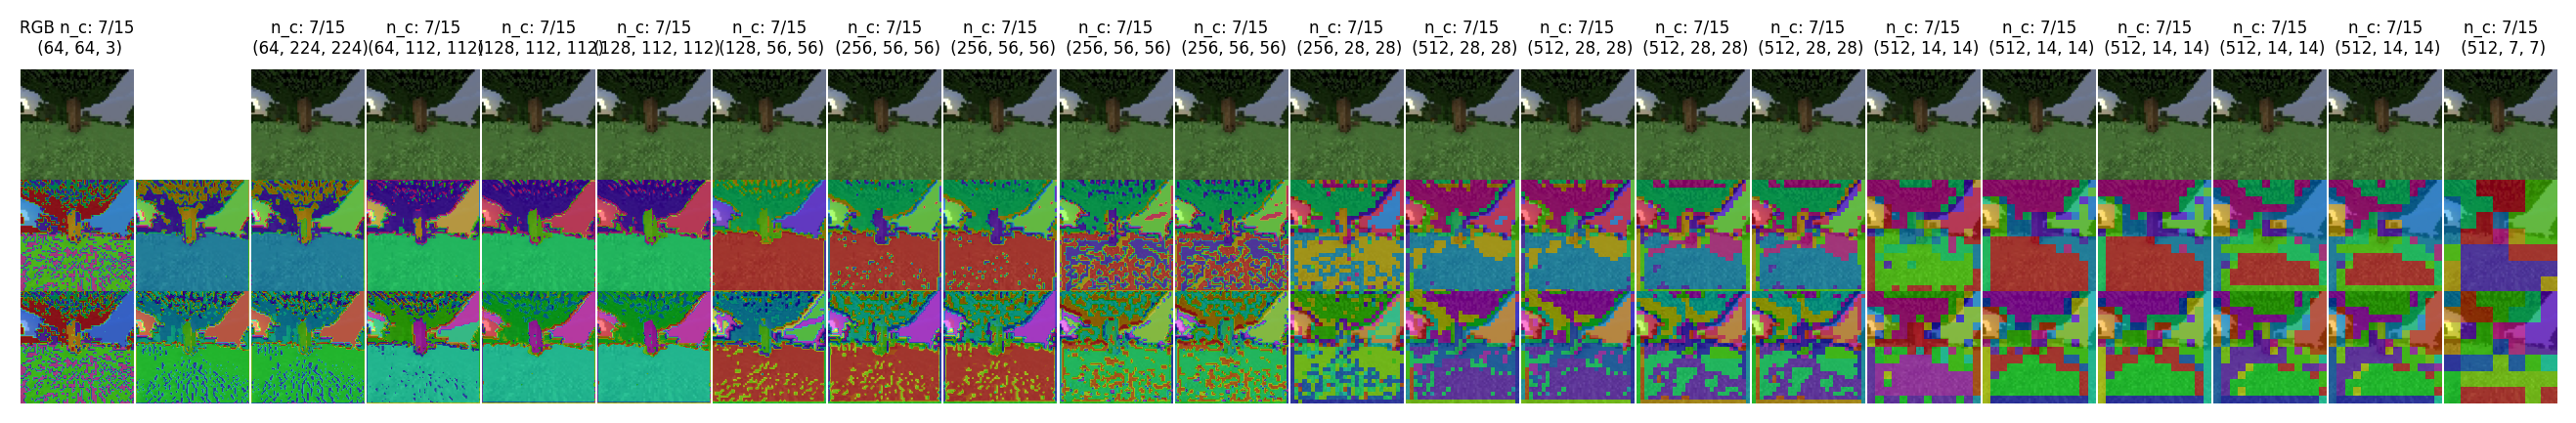

In [20]:
if True:
    models_vgg = train_cluster_models(vgg, iterator, trajectories, n_clusters=7)    

    for i in range(len(trajectories)):    
        visualize_clusters_video(vgg, trajectories[i], models_vgg, out_dir='out/vgg')
        # call(f"cd out && convert *.png -append mobilenetv2/layer_res{i:02}.png", shell=True)

In [ ]:
def visualize_clusters(model, trajectory: str, kmeans_models: dict[int, tuple[faiss.Kmeans, faiss.Kmeans]]):
    extent = 0, 63, 0, 63
    state_count = 0
    n_state_skip = 0

    for current_state, _, _, _, _ in iterator.data_pipeline.load_data(trajectory):
        if n_state_skip > 0 and n_state_skip < 20:
            n_state_skip += 1
            continue

        n_state_skip = 1

        pov = current_state['pov']

        _, intermediate_act = model.eval_intermediate(
            Tensor(pov))

        fig = plt.figure(figsize=(13, 2), dpi=200)
        vis_len = len(intermediate_act) + 1
        layer = 0

        for _act in intermediate_act:
            ref_ax = plt.subplot(3, vis_len, layer+2)
            act_ax = plt.subplot(3, vis_len, layer+vis_len+2)
            actX2_ax = plt.subplot(3, vis_len, layer+2*vis_len+2)

            _act = _act[0] if _act.shape[0] == 1 else _act

            kmeans, kmeansX2 = kmeans_models[layer]

            values = np.zeros((_act.shape[-2], _act.shape[-1]), dtype=int)
            for i in range(_act.shape[-2]):
                _, I = kmeans.index.search(
                    np.ascontiguousarray(_act[:, i, :].T.numpy()), 1)
                values[i, :] = np.array(I.T)
            valuesX2 = np.zeros((_act.shape[-2], _act.shape[-1]), dtype=int)
            for i in range(_act.shape[-2]):
                _, I = kmeansX2.index.search(
                    np.ascontiguousarray(_act[:, i, :].T.numpy()), 1)
                valuesX2[i, :] = np.array(I.T)

            cmap = cm.get_cmap('gist_rainbow', kmeans.k)
            cmapX2 = cm.get_cmap('gist_rainbow', kmeansX2.k)
            ref_ax.imshow(pov, extent=extent)
            act_ax.imshow(pov, alpha=1.0, extent=extent)
            # transpose as pov is transposed when creating tensor!
            act_ax.imshow(values.T, cmap=cmap, alpha=0.5, extent=extent)
            act_ax.axis('off')
            actX2_ax.imshow(pov, alpha=1.0, extent=extent)
            # transpose as pov is transposed when creating tensor!
            actX2_ax.imshow(valuesX2.T, cmap=cmapX2, alpha=0.5, extent=extent)
            actX2_ax.axis('off')
            ref_ax.axis('off')
            ref_ax.set_title(
                f"n_c: {kmeans.k}/{kmeansX2.k}\n {prettySize(_act.shape)}", fontdict={'fontsize': 6})

            layer += 1

        ref_ax = plt.subplot(3, vis_len, 1)
        act_ax = plt.subplot(3, vis_len, vis_len+1)
        actX2_ax = plt.subplot(3, vis_len, 2*vis_len+1)

        _act = np.array(pov, dtype=np.float32)

        kmeans, kmeansX2 = kmeans_models[-1]

        values = np.zeros((_act.shape[0], _act.shape[1]), dtype=int)
        for i in range(_act.shape[0]):
            _, I = kmeans.index.search(
                np.ascontiguousarray(_act[:, i, :]), 1)
            values[i, :] = np.array(I.T)
        valuesX2 = np.zeros((_act.shape[0], _act.shape[1]), dtype=int)
        for i in range(_act.shape[0]):
            _, I = kmeans.index.search(
                np.ascontiguousarray(_act[:, i, :]), 1)
            valuesX2[i, :] = np.array(I.T)

        cmap = cm.get_cmap('gist_rainbow', kmeans.k)
        cmapX2 = cm.get_cmap('gist_rainbow', kmeansX2.k)
        ref_ax.imshow(pov, extent=extent)
        act_ax.imshow(pov, alpha=1.0, extent=extent)
        # transpose as pov is transposed when creating tensor!
        act_ax.imshow(values.T, cmap=cmap, alpha=0.5, extent=extent)
        act_ax.axis('off')
        actX2_ax.imshow(pov, alpha=1.0, extent=extent)
        # transpose as pov is transposed when creating tensor!
        actX2_ax.imshow(valuesX2.T, cmap=cmapX2, alpha=0.5, extent=extent)
        actX2_ax.axis('off')
        ref_ax.axis('off')
        ref_ax.set_title(
            f"RGB n_c: {kmeans.k}/{kmeansX2.k}\n {prettySize(_act.shape)}", fontdict={'fontsize': 6})

        try:
            os.mkdir(f'out/')
        except:  # ignore already exists..
            None

        fig.tight_layout(pad=0.1)
        fig.savefig(f'out/{state_count}.png', facecolor='white')
        plt.close(fig)
        plt.clf()

        state_count += 1

        if state_count > 4:
            break

    plt.close()
